In [1]:
import player_model 
import draft_model 
import util
import final_model
from sklearn.metrics import brier_score_loss as brier_score
from sklearn.metrics import accuracy_score as acc_score
from sklearn.model_selection import train_test_split as tts
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

Load match data sourced from oracles elixir, and merge with player model information

In [2]:
match_data = util.load_match_data()
util.print_match_and_player_data(match_data)

,teamname,opponent,date,league,result,top_dif,jng_dif,mid_dif,bot_dif,sup_dif
0,ROX Tigers,KT Rolster,2017-01-17 07:10:23,LCK,0,-2.344660,-2.409820,-0.712900,-2.300489,-1.702800
1,KT Rolster,ROX Tigers,2017-01-17 07:10:23,LCK,1,2.344660,2.409820,0.712900,2.300489,1.702800
2,Longzhu Gaming,Samsung Galaxy,2017-01-17 10:04:07,LCK,1,0.248975,0.482163,0.973789,0.527127,1.420935
3,Samsung Galaxy,Longzhu Gaming,2017-01-17 10:04:07,LCK,0,-0.248975,-0.482163,-0.973789,-0.527127,-1.420935
4,bbq Olivers,MVP,2017-01-18 10:06:32,LCK,0,0.256832,-0.049755,0.121897,-1.606031,-0.198971


Fit the player model using the player differences. The logistic regression that uses draft information also interacts whether champions are most impactful in the early, mid, or late game.

In [3]:

player_model.calculate_positional_differences(match_data)
player_model.fit_player_model(match_data, use_draft_info=False)
player_model.fit_player_model(match_data, use_draft_info=True)
util.print_player_lead_probabilities(match_data)

,teamname,opponent,post_draft_top_lead_prob,post_draft_mid_lead_prob,post_draft_bot_lead_prob,draft_agnostic_top_lead_prob,draft_agnostic_mid_lead_prob,draft_agnostic_bot_lead_prob
0,ROX Tigers,KT Rolster,0.350542,0.353701,0.302976,0.326408,0.395956,0.323555
1,KT Rolster,ROX Tigers,0.660396,0.647507,0.698018,0.670732,0.604044,0.678149
2,Longzhu Gaming,Samsung Galaxy,0.511512,0.563308,0.612205,0.520898,0.571404,0.562983
3,Samsung Galaxy,Longzhu Gaming,0.481604,0.439663,0.404171,0.475864,0.428596,0.438935
4,bbq Olivers,MVP,0.511983,0.507584,0.382508,0.513222,0.506165,0.415071


Map each champion to its reduced role form. For each team sum over all comprising champions.

In [4]:
champion_mapping = draft_model.load_champion_mapping()
match_drafts = draft_model.reduce_team_drafts(match_data, champion_mapping)
util.print_team_reduced_drafts(match_drafts)

,id,team_Dives,team_Tanks,team_Damages,team_Enchanters,team_Picks,team_Pokes,team_Engages,team_Splitpushs,early_game,mid_game,late_game,ap,ad,no_damage_type
0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,2.0,2.0,0.0
1,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,1.0,3.0,1.0,2.0,2.0,0.0
2,2.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,2.0,3.0,0.0
3,3.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,0.0
4,4.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,3.0,1.0,2.0,2.0,0.0


Cluster all teams' drafts into 7 clusters.

In [5]:
N_clusters = 7
match_drafts = draft_model.cluster_drafts(match_drafts, n_clusters=N_clusters)
util.print_draft_centroids(match_drafts)

,team_Dives,team_Tanks,team_Damages,team_Enchanters,team_Picks,team_Pokes,team_Engages,team_Splitpushs,early_game,mid_game,late_game,no_damage_type
team_comp,,,,,,,,,,,,
0,0.332481,1.859518,1.249726,0.036536,0.297589,0.794118,0.422178,0.007855,0.925100,1.679028,2.395871,0.0
1,0.343992,0.488372,1.989503,0.026001,0.296673,0.261789,1.590278,0.003391,1.242087,1.800226,1.957687,0.0
2,0.517432,0.691560,1.255477,1.067822,0.290913,0.594018,0.543723,0.039055,1.514384,1.268242,2.217375,0.0
3,0.533745,0.572964,0.619749,0.161855,1.022297,1.156878,0.854669,0.077842,2.372686,1.680470,0.946845,0.0
4,1.235379,0.765526,1.044541,0.094333,0.350172,0.474742,0.981894,0.053413,1.077494,3.089625,0.832881,0.0
5,0.548780,1.295122,1.079268,0.413415,0.201220,0.451220,0.806098,0.204878,1.113415,1.926829,1.959756,1.0
6,0.240100,0.748791,1.081706,0.213223,0.383444,0.554202,0.741444,1.037090,1.001075,1.802544,2.196381,0.0


Merge information from draft clusters and player model win probabilities, and the list of composition that played against each in the dataset.

In [6]:

full_data, list_of_comp_diffs = util.merge_team_and_draft(match_data, match_drafts, N_clusters)

Train draft agnostic control model and final post draft model

In [7]:
train, test = tts(full_data, test_size=0.3, random_state=0)
draft_agnostic_model = final_model.train_draft_agnostic_model(train)
post_draft_model = final_model.train_post_draft_model(train, list_of_comp_diffs, full_data)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6179458645442352
            Iterations: 99
            Function evaluations: 100
            Gradient evaluations: 99


In [8]:

final_model.predict_with_model(full_data, draft_agnostic_model, "draft_agnostic")
final_model.predict_with_model(full_data, post_draft_model, "post_draft")

# How much did a team improve their win probability through draft
full_data["draft_diff"] = full_data["post_draft_win_prob"] - full_data["draft_agnostic_win_prob"]

util.print_win_prob_model_outputs(full_data)

,teamname,opponent,result,draft_agnostic_win_prob,post_draft_win_prob,draft_diff
0,ROX Tigers,KT Rolster,0,0.408006,0.277824,-0.130182
1,KT Rolster,ROX Tigers,1,0.591994,0.722176,0.130182
2,Longzhu Gaming,Samsung Galaxy,1,0.605627,0.636191,0.030564
3,Samsung Galaxy,Longzhu Gaming,0,0.394373,0.363809,-0.030564
4,bbq Olivers,MVP,0,0.325416,0.391558,0.066142


Print model statistics

In [9]:
# Using the same random state gives the same test train split
# We need to do this as the original model does not have the normalised win probs for each side of the match
train, test = tts(full_data, test_size=0.3, random_state=0)

def print_stats(model_name):
  print(f"""{model_name} Brier score: 
  {brier_score(test['result'], test[f'{model_name}_win_prob'])}\n
   {model_name} test accurary:
  {acc_score(test['result'], round(test[f'{model_name}_win_prob']))}
  """)

print_stats("draft_agnostic")
print("--------------------------")
print_stats("post_draft")

# Split into functions?

# TODO make it so the actual data already has this without a merge
merged_data = full_data.merge(match_data[["gameid","teamname", "bot_lead_at_15", "top_lead_at_15","mid_lead_at_15"]], how="inner", on=["gameid", "teamname"])

post_draft_average = np.average([
brier_score(merged_data["mid_lead_at_15"], merged_data["post_draft_mid_lead_prob"]),
brier_score(merged_data["top_lead_at_15"], merged_data["post_draft_top_lead_prob"]),
brier_score(merged_data["bot_lead_at_15"], merged_data["post_draft_bot_lead_prob"])])

draft_agnostic_average = np.average([
brier_score(merged_data["mid_lead_at_15"], merged_data["draft_agnostic_mid_lead_prob"]),
brier_score(merged_data["top_lead_at_15"], merged_data["draft_agnostic_top_lead_prob"]),
brier_score(merged_data["bot_lead_at_15"], merged_data["draft_agnostic_bot_lead_prob"])])

post_draft_acc_average = np.average([
acc_score(merged_data["mid_lead_at_15"], round(merged_data["post_draft_mid_lead_prob"])),
acc_score(merged_data["top_lead_at_15"], round(merged_data["post_draft_top_lead_prob"])),
acc_score(merged_data["bot_lead_at_15"], round(merged_data["post_draft_bot_lead_prob"]))])

draft_agnostic_acc_average = np.average([
acc_score(merged_data["mid_lead_at_15"], round(merged_data["draft_agnostic_mid_lead_prob"])),
acc_score(merged_data["top_lead_at_15"], round(merged_data["draft_agnostic_top_lead_prob"])),
acc_score(merged_data["bot_lead_at_15"], round(merged_data["draft_agnostic_bot_lead_prob"]))])

print(f"Draft agnostic acc {draft_agnostic_acc_average} \
        Post draft acc {post_draft_acc_average}")

print(f"Draft agnostic {draft_agnostic_average} \
        Post draft {post_draft_average}")

draft_agnostic Brier score: 
  0.23194302901675257

   draft_agnostic test accurary:
  0.6148001973359645
  
--------------------------
post_draft Brier score: 
  0.2153492244404107

   post_draft test accurary:
  0.6548593981253084
  


Import Bet 365 odds and adjust for the hold

In [10]:
bookie_odds = pd.read_csv("data/b365_odds.tsv", sep='\t')
bookie_odds["implied_win_prob"] = bookie_odds['implied_h_prob'] / (bookie_odds['implied_h_prob'] + bookie_odds['implied_a_prob'])
print("After adjusting for hold:")
print(f"""
Bookie Brier score:
{brier_score(bookie_odds['result'], bookie_odds['implied_win_prob'])}\n
Bookie accuracy
{acc_score(bookie_odds['result'], round(bookie_odds['implied_win_prob']))}
"""
)

After adjusting for hold:

Bookie Brier score:
0.22284981228499326

Bookie accuracy
0.6435495898583147



Ouput the calibration plot of the post draft model

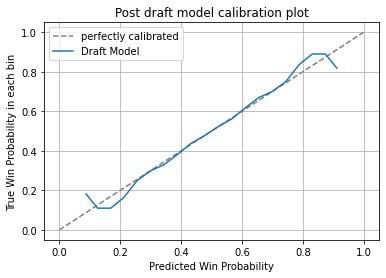

In [11]:
util.calibration_plot(full_data)

Output which teams in the LoL European Championship added the most expected wins as a result of draft through the 2022 Spring and Summer split

Text(0.5, 1.0, 'LoL European Championship Cumulative Expected Wins Added Through Draft')

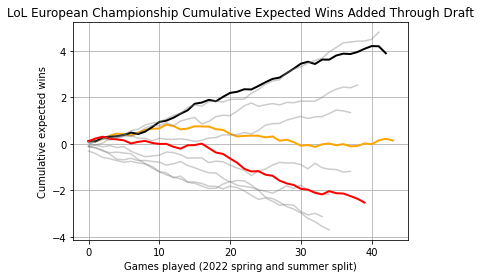

In [12]:
teams = {'G2 Esports' :'black', 'Fnatic':'orange', 'Misfits Gaming': 'red'}
ax = util.plot_cumulative_expected_wins_added_by_draft(full_data, league='LEC', teams=teams)
ax.set_title("LoL European Championship Cumulative Expected Wins Added Through Draft")

In [13]:
recent_LCS_games = full_data.query("league == 'LCS' & date > '2021-01-01'").copy()

new = recent_LCS_games.iloc[:, 14:63].idxmax(axis=1)
comp = new.str.split("_v_").to_list()
comp = [int(x[0].replace("team_comp", "")) for x in comp]
recent_LCS_games['teamcomp'] = comp
tc_games = recent_LCS_games.groupby("teamname", as_index=True)["teamcomp"].value_counts().to_frame("tc_count").reset_index()   #["teamcomp"].value_counts()
team_games = tc_games.pivot(index="teamname", columns="teamcomp", values="tc_count")
print(team_games.head(10))

teamcomp                 0     1     2     3     4    5     6
teamname                                                     
100 Thieves           16.0  19.0  18.0  20.0  25.0  NaN   8.0
Cloud9                14.0  23.0  20.0  16.0  16.0  2.0  19.0
Counter Logic Gaming   8.0  21.0  16.0  11.0  18.0  1.0  17.0
Dignitas              13.0  20.0  11.0  17.0  17.0  1.0  14.0
Evil Geniuses         16.0  26.0  14.0  14.0  27.0  NaN  10.0
FlyQuest              21.0  20.0  17.0  11.0  14.0  NaN  13.0
Golden Guardians      13.0  25.0  14.0   6.0  19.0  1.0  16.0
Immortals              8.0  26.0  14.0   8.0  18.0  1.0  17.0
TSM                    8.0  34.0  21.0  14.0  14.0  NaN   7.0
Team Liquid           14.0  29.0  13.0  10.0  11.0  3.0  30.0


In [14]:
# TL different from the mean
(team_games[6]["Team Liquid"] - team_games[6].mean()) / team_games[6].std()


2.255103654320168

In [15]:
# TODO this can be a little better lol
j = 1
for i, row in team_games.fillna(0).iterrows():
    if i != "Team Liquid": 
        continue
    labels = [str(x) for x in range(7)]
    tl_games = row

all_games_simple = team_games.sum(axis=0)
# TODO get the n numbers from the sums

Text(0.5, 0.98, 'Relative frequency of Team Draft clusters in the LCS')

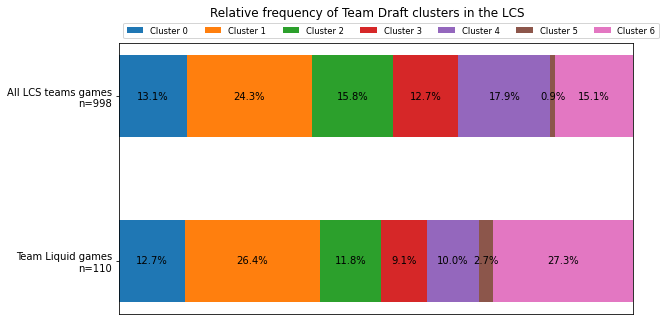

In [16]:
# put this into a function TODO
category_names = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5", "Cluster 6"]
results = {
    'All LCS teams games\nn=998': all_games_simple,
    'Team Liquid games\nn=110': tl_games
}

labels = list(results.keys())
data = np.array(list(results.values()))
totals = data.sum(axis=1)
data[0] /= totals[0]
data[1] /= totals[1]
data_cum = data.cumsum(axis=1)


fig, ax = plt.subplots(figsize=(9.2, 5))
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, 1)

for i, colname in enumerate(category_names):
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    rects = ax.barh(labels, widths, left=starts, height=0.5,
                    label=colname)

    ax.bar_label(rects, labels=[str(round(100*x,1)) + "%" for x in widths], label_type='center', fmt="%.2f")
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')

fig.suptitle("Relative frequency of Team Draft clusters in the LCS")

Text(0.5, 1.0, 'LoL Championship Series Cumulative Expected Wins Added Through Draft')

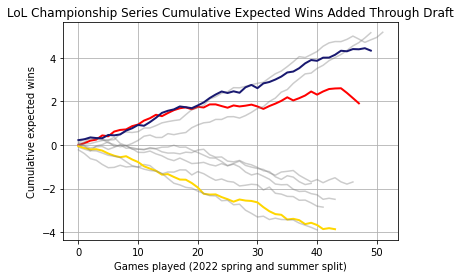

In [17]:
teams = {'Team Liquid' :'midnightblue', '100 Thieves':'red', 'Golden Guardians': 'gold'}
ax = util.plot_cumulative_expected_wins_added_by_draft(full_data, league='LCS', teams=teams)
ax.set_title("LoL Championship Series Cumulative Expected Wins Added Through Draft")

/home/alex/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


AttributeError: 'AxesSubplot' object has no attribute 'is_first_col'

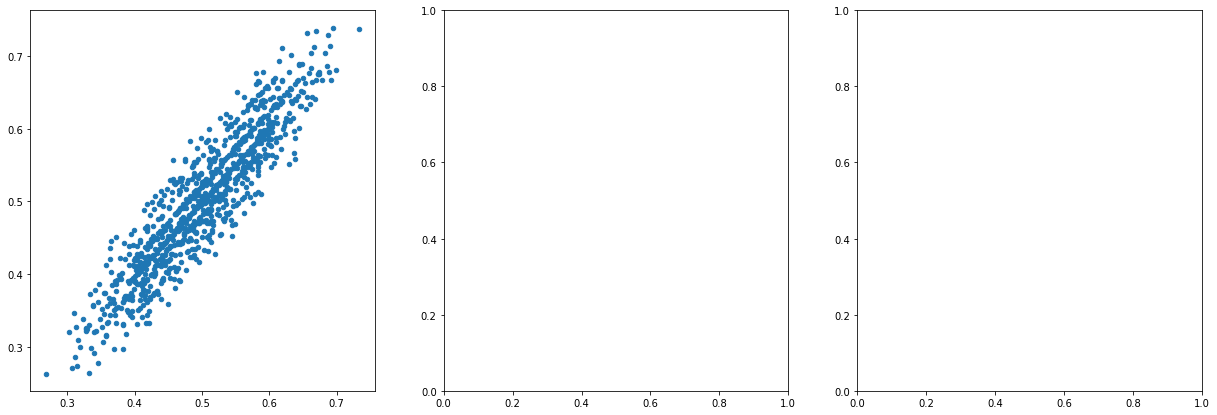

In [19]:
from sklearn import linear_model

reg_b = linear_model.LinearRegression().fit(recent_LCS_games[['draft_agnostic_bot_lead_prob']], recent_LCS_games[['post_draft_bot_lead_prob']])
reg_m = linear_model.LinearRegression().fit(recent_LCS_games[['draft_agnostic_mid_lead_prob']], recent_LCS_games[['post_draft_mid_lead_prob']])
reg_t = linear_model.LinearRegression().fit(recent_LCS_games[['draft_agnostic_top_lead_prob']], recent_LCS_games[['post_draft_top_lead_prob']])

r2_b = reg_b.score(recent_LCS_games[['draft_agnostic_bot_lead_prob']], recent_LCS_games[['post_draft_bot_lead_prob']])
r2_m = reg_m.score(recent_LCS_games[['draft_agnostic_mid_lead_prob']], recent_LCS_games[['post_draft_mid_lead_prob']])
r2_t = reg_t.score(recent_LCS_games[['draft_agnostic_top_lead_prob']], recent_LCS_games[['post_draft_top_lead_prob']])

fig, ax = plt.subplots(1, 3, figsize=(21,7))

recent_LCS_games.plot(ax=ax[0], kind='scatter', x='draft_agnostic_bot_lead_prob', y="post_draft_bot_lead_prob")
recent_LCS_games.plot(ax=ax[1], kind='scatter', x='draft_agnostic_mid_lead_prob', y="post_draft_mid_lead_prob")
recent_LCS_games.plot(ax=ax[2], kind='scatter', x='draft_agnostic_top_lead_prob', y="post_draft_top_lead_prob")

ax[0].plot((0.2,0.8), (0.2,0.8), color='orange', label=f"R^2 = {r2_b}")
ax[1].plot((0.2,0.8), (0.2,0.8), color='orange', label=f"R^2 = {r2_m}")
ax[2].plot((0.2,0.8), (0.2,0.8), color='orange', label=f"R^2 = {r2_t}")

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].set_title("Bot lane")
ax[1].set_title("Mid lane")
ax[2].set_title("Top lane")

fig.suptitle("Pre/post draft lead advantages")

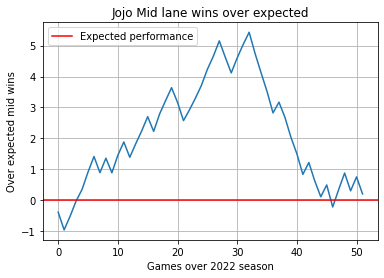

In [23]:
# TODO pull into functions

fig, ax = plt.subplots()
merged_data = full_data.merge(match_data[["gameid","teamname", "bot_lead_at_15", "top_lead_at_15","mid_lead_at_15"]], how="inner", on=["gameid", "teamname"])
recent_EG_games = merged_data.query("teamname == 'Evil Geniuses' and date > '2022-01-01'").copy()
recent_EG_games["mid_wins"] = recent_EG_games["mid_lead_at_15"] - recent_EG_games["post_draft_mid_lead_prob"]
wins_above = recent_EG_games[["mid_wins"]].cumsum()
ax.plot(range(len(wins_above)), wins_above)

ax.set_title("Jojo Mid lane wins over expected")
ax.set_xlabel("Games over 2022 season")
ax.set_ylabel("Over expected mid wins")
ax.grid()
ax.axhline(0, color='r', label="Expected performance")
ax.legend();